In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# less common imports
import matplotlib.image as mpimg
from pygam import LinearGAM, GAM, s, l
from sklearn import preprocessing
from scipy import stats
from scipy import spatial
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import shutil
import gc
from seaborn import clustermap
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import sys
sys.path.insert(0, '../')
import new_misc_code as nmc 

## **Format logTMM data from limma-voom into workable form for GAM curve fitting**

In [3]:
# Set path and read in logTMM normalized data from limma-voom output directories
# These directories can be downloaded from http://brain.listerlab.org/Major-Traj-Limma-Voom.html
dt_path = "../data/limma-voom/"
dt_fls = os.listdir( path=dt_path)

In [4]:
# read in anndata for obs
adata = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")
obs_df = adata.obs
# clean up dataframe by dropping all duplicates of batch entries
obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

In [5]:
# select for limma dev-traj directories
###############################
dt_oi = "glimma_dev-traj_"
###############################
oi_fls = [ii for ii in dt_fls if dt_oi in ii]
oi_fls

['glimma_dev-traj_Astro',
 'glimma_dev-traj_ID2',
 'glimma_dev-traj_L2-3_CUX2',
 'glimma_dev-traj_L4_RORB',
 'glimma_dev-traj_L5-6_THEMIS',
 'glimma_dev-traj_L5-6_TLE4',
 'glimma_dev-traj_LAMP5_NOS1',
 'glimma_dev-traj_Micro',
 'glimma_dev-traj_Oligo',
 'glimma_dev-traj_OPC',
 'glimma_dev-traj_Poor-Quality',
 'glimma_dev-traj_PV',
 'glimma_dev-traj_PV_SCUBE3',
 'glimma_dev-traj_SST',
 'glimma_dev-traj_Vas',
 'glimma_dev-traj_VIP']

In [6]:
# 1) read in results files for each and pull sig genes
# 2) read in pseudo-bulk logTMM from limma voom
sig_genes = {}
logTMMs = {}
for fl_itr in oi_fls:
    # clean up file name to use as dict key
    key = fl_itr.replace("glimma_", "")
    key = key.split('-obs')[0]
    key = key.split('dev-traj_')[1]
    # skip poor quality nucs
    if key=='Poor-Quality':
        continue
    # read in results file
    results = pd.read_table( f"{dt_path}{fl_itr}/results_file.txt")
    # find and pull all results columns 
    res_cols = [ii for ii in results.columns if 'Res' in ii]
    res_df = results[res_cols]
    
    # find all genes signifcant for any stage comparison
    sig_mk = np.any( ( res_df!=0).values, axis=1)
    # if no sig genes found skip run
    if( sum(sig_mk)==0):
        print( f"No sig genes found for {key}")
        continue
    # set to dict
    sig_genes[key] = results.index.values[sig_mk]
    
    # read in pseudo-bulk logTMM
    bk_df = pd.read_csv( f"{dt_path}{fl_itr}/logTMM_cts.csv", index_col=[0])
    # clean up columns labels, make them batch
    bk_df.columns = [ii.split('..')[1] for ii in bk_df.columns.values]
    # order columns by age of maturation
    batch_mk = np.in1d( adata.uns['batch_order'], bk_df.columns)
    batch_order_itr = np.array( adata.uns['batch_order'])[batch_mk]
    bk_df = bk_df[batch_order_itr]
    # reduce bulk data to sig genes only
    sig_bk_df = bk_df.loc[sig_genes[key]]
    print(key)
    # set to dict
    logTMMs[key] = sig_bk_df
# sig_genes

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
No sig genes found for Vas
VIP


In [28]:
# save to use in future analysis
nmc.save_obj( logTMMs, f"../data/logTMMs.pkl")

In [7]:
for iii, jjj in sig_genes.items():
    print( iii, jjj.shape)

Astro (3497,)
ID2 (3755,)
L2-3_CUX2 (8842,)
L4_RORB (8885,)
L5-6_THEMIS (6924,)
L5-6_TLE4 (7239,)
LAMP5_NOS1 (2514,)
Micro (58,)
Oligo (2540,)
OPC (1321,)
PV (5558,)
PV_SCUBE3 (2745,)
SST (4377,)
VIP (4624,)


In [8]:
# example logTMM dataframe
logTMMs['Astro'].head()

,RL2103_ga22_v3,RL2107_ga24_v3,RL2121_ga34_v3,RL1777_2d_v3,RL1612_34d_v2,RL2100_86d_v3,RL2104_118d_v3,RL2108_179d_v3,RL2122_301d_v3,RL2125_422d_v3,...,RL2110_10yr_v3,RL2126_10yr_v3,RL2127_12yr_v3,RL2130_14yr_v3,RL2102_16yr_v3,RL2131_17yr_v3,RL2123_20yr_v3,RL2128_20yr_v3,RL2132_25yr_v3,RL2124_40yr_v3
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


In [9]:
# change column names in each logTMM to stage of batch
# will use these values as x-axis in curve fitting
plot_labels = {}
for key_itr in logTMMs.keys():
    new_cols = []
    for col_itr in logTMMs[key_itr]:
        age_itr = obs_df['stage_id'][obs_df['batch']==col_itr].values[0]
        new_cols.append( age_itr)
    plot_labels[key_itr] = [ii.split('_')[1] for ii in logTMMs[key_itr].columns]
    logTMMs[key_itr].columns = new_cols

In [10]:
logTMMs['Astro'].head()

,Fetal,Fetal,Fetal,Neonatal,Neonatal,Infancy,Infancy,Infancy,Infancy,Childhood,...,Adolescence,Adolescence,Adolescence,Adolescence,Adolescence,Adolescence,Adult,Adult,Adult,Adult
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


## **Fit GAM to each gene across stages**

In [11]:
# This will take a while to run
n_splines = 12
n_grid_pts = 100
stage_order = adata.uns['stage_order'].tolist()
gam_fits = {}
r_sqr_dict = {}
rates = {}
for key_itr, sig_df in logTMMs.items(): 
    # set x-axis for dev-traj using column values
    ax = [stage_order.index(ss) for ss in logTMMs[key_itr]]
    # list to hold R^2 values
    r_sqr = []
    # dataframe to hold fits
    fits_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts), dtype=float), index=sig_df.index)
    # dataframe to hold rates
    rates_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts-1), dtype=float), index=sig_df.index)
    for gene_itr in sig_df.index:
        # y-axis gene values
        ay = sig_df.loc[gene_itr,:].values
        # fit GAM
        gam = LinearGAM( s( 0, lam=0.6, n_splines=n_splines), fit_intercept=False).fit( ax, ay)
        axx = gam.generate_X_grid( term=0, n=n_grid_pts)
        yyy = gam.predict( X=axx)

        fits_df.loc[gene_itr,:] = yyy
        rates_df.loc[gene_itr,:] = np.diff( yyy)
        r_sqr.append( gam.statistics_['pseudo_r2']['explained_deviance'])
        
    gam_fits[key_itr]   = fits_df  
    r_sqr_dict[key_itr] = np.array( r_sqr)
    rates[key_itr] = rates_df
    print( key_itr)  

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
VIP


In [13]:
# save to use in future analysis
nmc.save_obj( gam_fits, f"../data/STAGE_gam_fits_12_grid{n_grid_pts}.pkl")
nmc.save_obj( r_sqr_dict, f"../data/STAGE_rsqr_fits_12_grid{n_grid_pts}.pkl")

## **Plot trend fits**

In [22]:
def plot_trend( gene, trend_df, scat_df, n_grid_pts=n_grid_pts):
    if isinstance( gene, int):
        gene = trend_df.index.values[gene]
    plt.figure( figsize=(10,4))
    # plot trend fit      
    trend = trend_df.loc[gene]
    plt.plot( range( len(trend)), trend, color='orange')
    # plot TMM bulk points
    scat_x = [stage_order.index(ss) for ss in scat_df.columns.values]
    num_stages = len(np.unique(scat_df.columns))
    scat_x = np.array( scat_x) * (n_grid_pts/(num_stages-1))
    scat = scat_df.loc[gene,:]
    plt.scatter( scat_x, scat);    
    # plot attributes
    ticks = np.linspace(0, n_grid_pts, num_stages)
    plt.xticks( ticks=ticks, labels=stage_order, rotation=90);
    plt.title( f"{gene}")
    plt.ylabel('log2(TMM) CPM')
    return

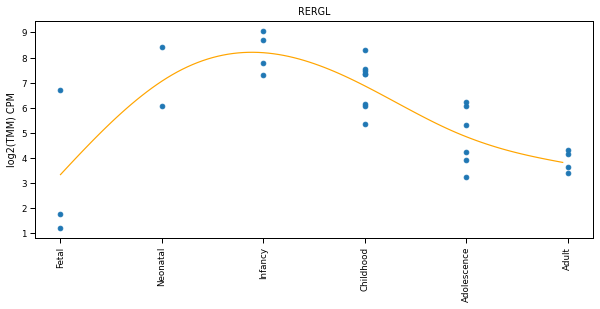

In [23]:
plot_trend( "RERGL", gam_fits['L2-3_CUX2'], logTMMs['L2-3_CUX2'])

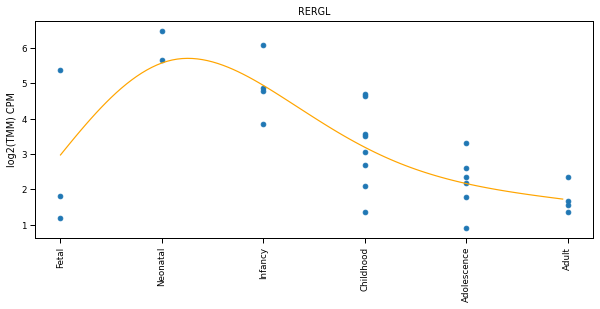

In [24]:
plot_trend( "RERGL", gam_fits['L4_RORB'], logTMMs['L4_RORB'])

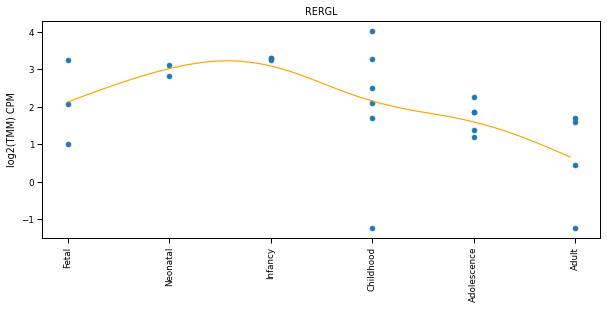

In [25]:
plot_trend( "RERGL", gam_fits['L5-6_THEMIS'], logTMMs['L5-6_THEMIS'])

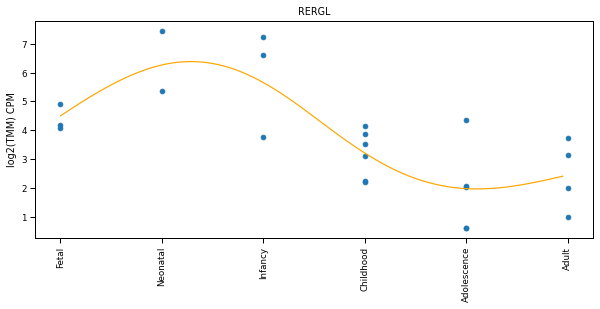

In [26]:
plot_trend( "RERGL", gam_fits['L5-6_TLE4'], logTMMs['L5-6_TLE4'])